In [1]:
import matplotlib.pyplot as plt

from IPython.display import display

from tqdm import tqdm_notebook

import math
import numpy as np
import time

from PIL import Image

import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torchvision.transforms as transforms

from warpctc_pytorch import CTCLoss

from utilities import HYPERPARAMETERS, Metric, torch_weight_init, print_model_summary, DelayedKeyboardInterrupt, \
    plot_learning_curves, visualize_data, SequenceWise
from vocabulary import Vocabulary
from dataloader import DataArgumentation, FromNumpyToTensor, IAMHandwritingDataset, alignCollate, ResizeAndPad
from checkpoint import Checkpoint
from models import CRNN
from decoder import CTCGreedyDecoder
from stopping import Stopping
from logger import PytorchLogger, TensorboardLogger
from spelling import Spelling
from trainer import Trainer
from evaluator import Evaluator
from recognizer import Recognizer
from scorer import Scorer, SpellingScorer

In [2]:
#torch.cuda.is_available = lambda : False
#torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = True

In [3]:
seed = 0
np.random.seed(0)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [4]:
H = HYPERPARAMETERS({
    'MODEL_PATH': './chkpt/IAM_HTR_CTC05.tar',
    'ROOT_DIR': './data',
    'EXPERIMENT': 'IAM_HTR_CTC05',
    'BATCH_SIZE': 16,
    'HEIGHT': 64,
    'PADDING': 10,
    'NUM_WORKERS': 8,
    'HIDDEN_SIZE': 256,
    'NUM_LAYERS': 2,
    'RNN_DROPOUT': 0.5,
    'LR': 0.0003,
    'LR_LAMBDA': lambda epoch: max(math.pow(0.78, math.floor((1 + epoch) / 11.0)), 0.4),
    'WEIGHT_DECAY': 0,
    'MAX_GRAD_NORM': 5.,
    'ARGUMENTATION': 0.9,
    'STOPPING_PATIENCE': 10,
    'NUM_EPOCHS': 50,
    
    'CHECKPOINT_FILE': 'IAM_HTR_CTC05',
    'CHECKPOINT_INTERVAL': 5,
    'CHECKPOINT_RESTORE': False,
    
    'USE_CUDA': torch.cuda.is_available(),
})

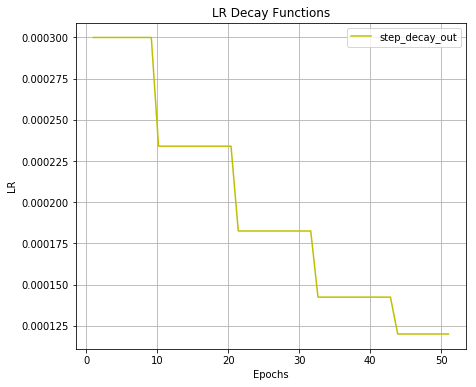

In [5]:
#https://research.fb.com/wp-content/uploads/2017/06/imagenet1kin1h5.pdf?

max_epochs = H.NUM_EPOCHS
epts = np.linspace(1, max_epochs+1, max_epochs)
step_decay_out = np.vectorize(H.LR_LAMBDA)(epts) * H.LR

plt.figure(figsize=(7,6))
plt.plot(epts,step_decay_out, label='step_decay_out', color='y')
plt.title("LR Decay Functions")
plt.xlabel("Epochs");
plt.ylabel("LR");
plt.grid(True)
plt.legend(loc='upper right');

In [6]:
import os
from glob import glob
from os.path import basename

import json
import random
import numpy as np
import re
import math

import PIL
from PIL import Image

import torch
import torch.utils.data as data
import torchvision.transforms as transforms

import tensorlayer.prepro as prepro


class IAMHandwritingDataset(data.Dataset):
    """IAM Handwriting Database ( http://www.fki.inf.unibe.ch/databases/iam-handwriting-database )"""

    def __init__(self, root, vocab, dataset, transform=None, target_transform=None, max_size=None):
        self.root = root
        self.vocab = vocab
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform
        self.max_size = max_size
        
        
        self.annotations = []
        self.max_seq_length = 0
        self.index = []

        self.annotations, self.max_seq_length = self.load_annotations(root, dataset)
        self.index = self.load_index(root)
        
        if isinstance(self.max_size, int):

            assert self.max_size < len(self.annotations) # max_train_size needs to select a subset

            self.annotations = random.sample(self.annotations, self.max_size)

    def __getitem__(self, index):
        annotation = self.annotations[index]
        line_id = annotation['line_id']
        path = self.index[line_id]

        image = Image.open(path).convert('L')
        if self.transform is not None:
            image = self.transform(image)

        target = annotation['transcript']
        target = [self.vocab(token) for token in target]
        target = np.array(target)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return image, target

    def __len__(self):
        return len(self.annotations)

    @classmethod
    def create(cls, root):
        path = os.path.join(root, 'part/lines/aachen/tr.lst')
        with open(path, 'r') as infile:
            trainset = {v.strip() for v in infile.readlines()}
            
        path = os.path.join(root, 'part/lines/aachen/va.lst')
        with open(path , 'r') as infile:
            validationset1 = {v.strip() for v in infile.readlines()}
       
        try:
            path = os.path.join(root, 'part/lines/aachen/va2.lst')
            with open(path, 'r') as infile:
                validationset2 = {v.strip() for v in infile.readlines()}
        except:
            validationset2 = {}
        
        path = os.path.join(root, 'part/lines/aachen/te.lst')
        with open(path, 'r') as infile:
            testset = {v.strip() for v in infile.readlines()}
            
        file_index = cls.load_index(root)

        path = os.path.join(root, 'ascii/lines.txt')

        annotations = []
        max_seq_length = 0
        with open(path, "r") as fd:
            for idx, line in enumerate(fd.readlines()):
                if '#' in line[0]:
                    continue
                fields = line.rstrip().split(" ")
                
                transcript = fields[8]
                # transcript field has whitespaces in it - need to fix the erroneous splits
                if len(fields) > 9:
                    for i in range(9, len(fields)):
                        transcript += fields[i]
                    
                # replace | seperator with whitespace
                transcript = transcript.replace("|", " ")   
    
                l = len(transcript)                
                if not l:
                    continue
                
                if l > max_seq_length:
                    max_seq_length = l
    
                annotation={
                    'line_id': fields[0],
                    'seg_result': fields[1],
                    'graylevel': fields[2],
                    'components': fields[3],
                    'bounding_box':[fields[4], fields[5], fields[6], fields[7]],
                    'transcript': transcript
                }

                line_id = annotation['line_id']
                path = file_index[line_id]
                try:
                    _ = Image.open(path)
                except IOError:
                    print('Corrupted image for %s ' % path)
                    continue

                if not line_id in file_index:
                    print('File missing %s' % path)
                    continue

                line_id = annotation['line_id']#[:-4]
                
                if line_id in trainset:
                    dataset = "train"
                elif line_id in validationset1:
                    dataset = "valid1"
                elif line_id in validationset2:
                    dataset = "valid2"
                elif line_id in testset:
                    dataset = "test"
                else:
                    dataset = "train"

                annotation['dataset'] = dataset

                annotations.append(annotation)

        path = os.path.join(root, 'annotations.json')

        with open(path, 'w') as outfile:
            json.dump({'annotations': annotations,
                      'max_seq_length': max_seq_length},
                      outfile)

    @classmethod
    def load_annotations(cls, root, dataset):
        path = os.path.join(root, 'annotations.json')

        with open(path, "r") as fd:
            content = json.load(fd)

        if not len(content):
            raise RuntimeError('Dataset empty.')

        annotations = content['annotations']
        max_seq_length = content['max_seq_length']
            
        if "train" in dataset:
            annotations = [a for a in annotations if 'train' in a['dataset']]
        elif "valid" in dataset:
            annotations = [a for a in annotations if 'valid1' in a['dataset'] or 'valid2' in a['dataset']]
        elif "test" in dataset:
            annotations = [a for a in annotations if 'test' in a['dataset']]
        else:
            raise RuntimeError('Dataset parameter can be: "train", "valid" or "test".')

        return annotations, max_seq_length

    @classmethod
    def load_index(cls, root):
        path = os.path.join(root, 'imgs/lines_h64/') + "*.jpg"
        files = glob(path)
        
        index = dict([(basename(path).rstrip(".jpg") , path) for path in files])

        if not len(index):
            raise RuntimeError('Image files empty.')
        return index

    def __repr__(self):
        fmt_str = self.__class__.__name__ + '\n'
        fmt_str += '    Number of images found: {}\n'.format(len(self.index))
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [7]:
import os
import json

class Vocabulary(object):
    def __init__(self, root_dir):
        self.token2idx = {}
        self.idx2token = {}
        self.idx = 0
        self.path = os.path.join(root_dir, 'vocab.json')

        self.add('') # extra output dimension for the BLANK label required for CTC loss

    def add(self, token):
        if not token in self.token2idx:
            self.token2idx[token] = self.idx
            self.idx2token[self.idx] = token
            self.idx += 1

    def __call__(self, val):
        res = None
        if isinstance(val, str):
            res = self.token2idx[val] if val in self.token2idx else self.token2idx['']
        elif isinstance(val, int):
            res = self.idx2token[val] if val <= self.__len__() else self.token2idx['']
        else:
            raise RuntimeError
        return res

    def __len__(self):
        return len(self.token2idx)

    def create(self, alphabet):
        for c in alphabet:
            self.add(c)

    def dump(self):
        data = {'idx': self.idx, 'token2idx':self.token2idx, 'idx2token':self.idx2token}
        with open(self.path, "w") as fd:
            json.dump(data, fd)

    def load(self):
        with open(self.path, "r") as fd:
            data = json.load(fd)
            self.idx = int(data['idx'])
            self.token2idx = data['token2idx']
            self.idx2token = {int(k):v for k,v in data['idx2token'].items()}

    def __repr__(self):
        fmt_str = self.__class__.__name__ + '\n'
        fmt_str += '    Number of tokens: {}\n'.format(self.__len__())
        return fmt_str

In [8]:
# IAMHandwritingDataset.create('./data/IAM/')
# vocab = Vocabulary("./data/IAM/")
# train_dataset = IAMHandwritingDataset('./data/IAM/', vocab, dataset="train")
# len(train_dataset.annotations[0]['transcript'])
# train_dataset.annotations[0]['transcript']
# d = {}
# for ann in train_dataset.annotations:
#     for c in ann['transcript']:
#         d[c] = 1 if not c in d else d[c] + 1
# vocab.create(sorted(list(d.keys())))
# vocab.dump()

In [9]:
vocab = Vocabulary("./data/IAM/")
vocab.load()
vocab

Vocabulary
    Number of tokens: 80

In [10]:
class DataArgumentation(object):
    def __init__(self, threshold=0.5):
        self.threshold = threshold

    def __call__(self, img):
        if random.random() < self.threshold:
            img = np.array(img)
            img = img.reshape(1, img.shape[0], img.shape[1])

#             img = prepro.rotation(img, 5, is_random=True, row_index=1, col_index=2, channel_index=0)
            img = prepro.shift(img, 0.01, 0.04, is_random=True, row_index=1, col_index=2, channel_index=0)
#             img = prepro.shear(img, intensity=0.1, is_random=True, row_index=1, col_index=2, channel_index=0)
#             img = prepro.zoom(img, (1.0, 1.2), is_random=True, row_index=1, col_index=2, channel_index=0)

            img = prepro.elastic_transform(img.squeeze(0), is_random=True, alpha=5.5, sigma=35, cval=0.0)

            img = Image.fromarray(img)
        return img


In [11]:
image_transform_train = transforms.Compose([
    transforms.Pad((H.PADDING, H.PADDING, H.PADDING, H.PADDING), fill=255),
#     DataArgumentation(threshold=H.ARGUMENTATION),
    transforms.ToTensor(),
])

image_transform_test = transforms.Compose([
    transforms.Pad((H.PADDING, H.PADDING, H.PADDING, H.PADDING), fill=255),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    FromNumpyToTensor()
])

In [12]:
train_dataset = IAMHandwritingDataset('./data/IAM/', vocab, dataset="train", #max_size=10000,
                                     transform=image_transform_train, target_transform=target_transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=H.BATCH_SIZE, num_workers=H.NUM_WORKERS, shuffle=True,
    collate_fn=alignCollate(img_height=H.HEIGHT), pin_memory=True)

train_dataset, len(train_loader)

(IAMHandwritingDataset
     Number of images found: 13353
     Number of datapoints: 9472
     Root Location: ./data/IAM/
     Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1cb0d40e10>
     Target Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1cb0d40470>,
 592)

In [13]:
valid_dataset = IAMHandwritingDataset('./data/IAM/', vocab, dataset="valid", #max_size=200,
                                     transform=image_transform_test, target_transform=target_transform)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=H.BATCH_SIZE, shuffle=False, num_workers=H.NUM_WORKERS, 
    collate_fn=alignCollate(img_height=H.HEIGHT), pin_memory=True)

valid_dataset, len(valid_loader)

(IAMHandwritingDataset
     Number of images found: 13353
     Number of datapoints: 966
     Root Location: ./data/IAM/
     Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1cb0d40860>
     Target Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1cb0d40470>,
 61)

In [14]:
test_dataset = IAMHandwritingDataset('./data/IAM/', vocab, dataset="test", 
                                     transform=image_transform_test, target_transform=target_transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=H.BATCH_SIZE, shuffle=False, num_workers=H.NUM_WORKERS,
    collate_fn=alignCollate(img_height=H.HEIGHT))

test_dataset, len(test_loader)

(IAMHandwritingDataset
     Number of images found: 13353
     Number of datapoints: 2915
     Root Location: ./data/IAM/
     Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1cb0d40860>
     Target Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1cb0d40470>,
 183)

In [15]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

input_vars, target_vars, input_sizes, target_len = next(train_loader.__iter__())

print(input_vars.shape, target_vars.shape)

@interact(idx=(0, H['BATCH_SIZE']-1))
def show(idx):
    print(input_vars[idx].shape)
    visualize_data(input_vars[idx], target_vars[idx], vocab)

torch.Size([16, 1, 64, 1257]) torch.Size([16, 63])


interactive(children=(IntSlider(value=7, description='idx', max=15), Output()), _dom_classes=('widget-interact',))

In [16]:
type(input_vars[0].numpy())

numpy.ndarray

<IPython.core.display.Javascript object>


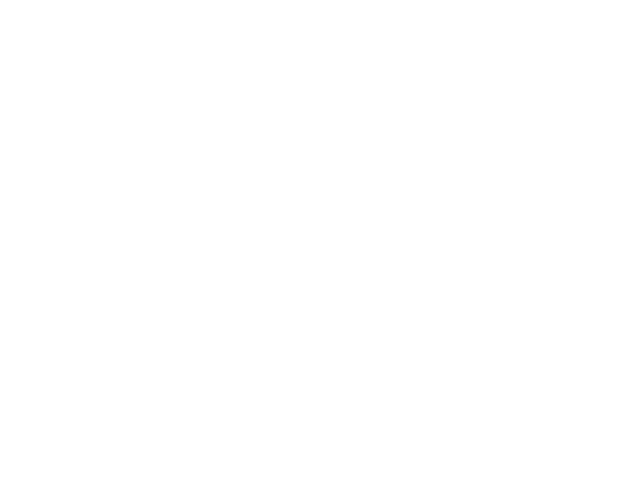

interactive(children=(IntSlider(value=8, description='idx', max=16), IntSlider(value=0, description='x', max=1, min=-1), Output()), _dom_classes=('widget-interact',))

In [17]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

im = plt.imshow(input_vars[0].squeeze(0), cmap='binary')

@interact(idx=(0,input_vars.size(0)), x=(-1,1))
def rotate(idx, x):
    img = input_vars[idx].numpy()
    img = img.reshape(1, img.shape[1], img.shape[2])
    
    img_out = prepro.rotation(img, x, is_random=False, row_index=1, col_index=2, channel_index=0)
    im.set_data(img_out.squeeze(0))

<IPython.core.display.Javascript object>


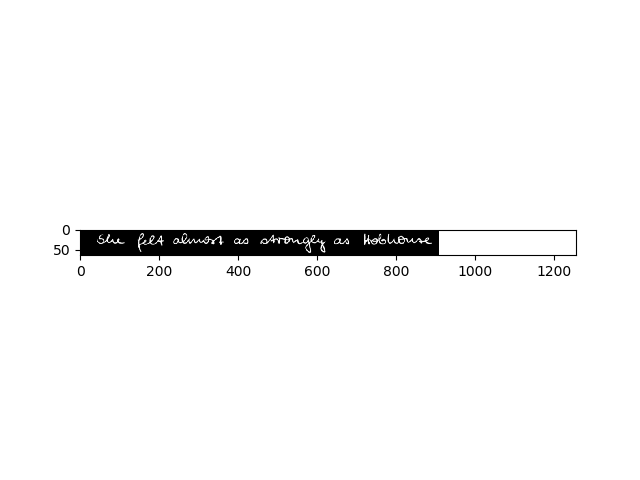

interactive(children=(IntSlider(value=8, description='idx', max=16), FloatSlider(value=0.0, description='wrg', max=0.2, min=-0.2), FloatSlider(value=0.0, description='hrg', max=0.4, min=-0.4), Output()), _dom_classes=('widget-interact',))

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

im = plt.imshow(input_vars[0].squeeze(0), cmap='binary')

@interact(idx=(0,input_vars.size(0)), wrg=(-0.2,0.2), hrg=(-0.4,0.4))
def shift(idx, wrg, hrg):
    img = input_vars[idx].numpy()
    img = img.reshape(1, img.shape[1], img.shape[2])
    
    img_out = prepro.shift(img, wrg/10, hrg/10, is_random=False, row_index=1, col_index=2, channel_index=0)
    im.set_data(img_out.squeeze(0))

<IPython.core.display.Javascript object>


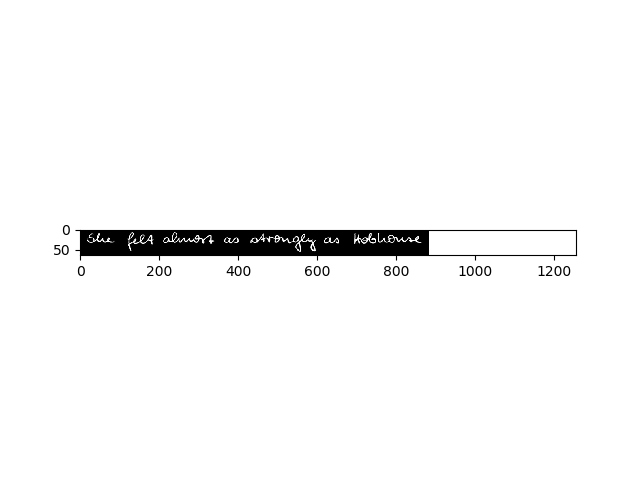

interactive(children=(IntSlider(value=8, description='idx', max=16), FloatSlider(value=0.05, description='intensity', max=0.1), Output()), _dom_classes=('widget-interact',))

In [24]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

im = plt.imshow(input_vars[0].squeeze(0), cmap='binary')

@interact(idx=(0,input_vars.size(0)), intensity=(0.0,0.1))
def shear(idx, intensity):
    img = input_vars[idx].numpy()
    img = img.reshape(1, img.shape[1], img.shape[2])
        
    img_out = prepro.shear(img, intensity=intensity/10, is_random=False, row_index=1, col_index=2, channel_index=0)
    im.set_data(img_out.squeeze(0))

<IPython.core.display.Javascript object>


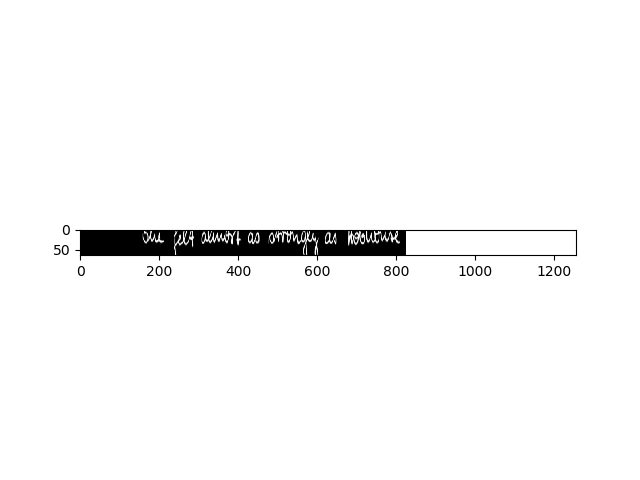

interactive(children=(IntSlider(value=8, description='idx', max=16), FloatSlider(value=0.5, description='x', max=1.0), FloatSlider(value=0.65, description='y', max=1.3), Output()), _dom_classes=('widget-interact',))

In [29]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

im = plt.imshow(input_vars[0].squeeze(0), cmap='binary')

@interact(idx=(0,input_vars.size(0)), x=(0.0,1.0), y=(0.0,1.3))
def zoom(idx, x, y):
    img = input_vars[idx].numpy()
    img = img.reshape(1, img.shape[1], img.shape[2])
        
    img_out = prepro.zoom(img, (x, y), is_random=False, row_index=1, col_index=2, channel_index=0)
    im.set_data(img_out.squeeze(0))

<IPython.core.display.Javascript object>


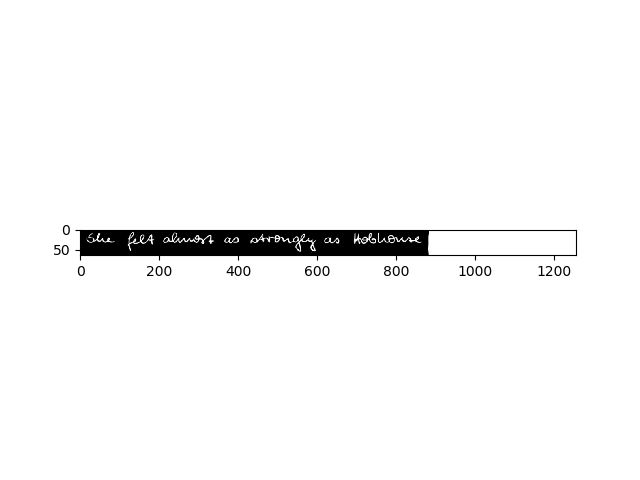

interactive(children=(IntSlider(value=8, description='idx', max=16), IntSlider(value=35, description='alpha', max=50, min=20), FloatSlider(value=5.5, description='sigma', max=7.0, min=4.0), Output()), _dom_classes=('widget-interact',))

In [32]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

im = plt.imshow(input_vars[0].squeeze(0), cmap='binary')

@interact(idx=(0,input_vars.size(0)), alpha=(20,50), sigma=(4.0,7.0))
def elastic_transform(idx, alpha, sigma):
    img = input_vars[idx].numpy()
    img = img.reshape(1, img.shape[1], img.shape[2])
    
    img_out = prepro.elastic_transform(img.squeeze(0), alpha=alpha, sigma=sigma, cval=0.0)
    im.set_data(img_out)